In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-07-03 22:02:53.792762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751580173.816195   10123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751580173.823245   10123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Loaded images: (4587, 256, 384, 3), Labels: (4587,)
✅ Classes: ['-1', '0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']
✅ Train: (3669, 256, 384, 3) (3669, 16)
✅ Val: (918, 256, 384, 3) (918, 16)


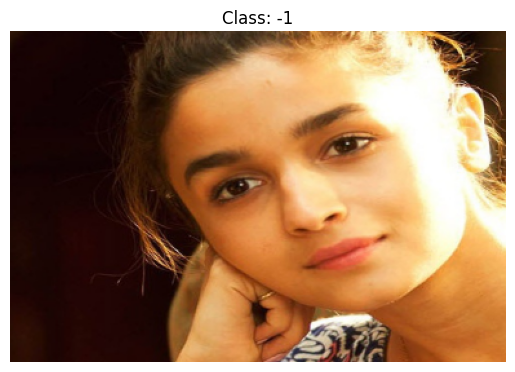

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import keras

# === CONFIG ===
IMG_SIZE = (256, 384)
DATA_DIR = "/kaggle/input/project-dataset/Train"

# === LOAD DATA ===
X = []
y = []
label_names = []

for folder in sorted(os.listdir(DATA_DIR)):
    folder_path = os.path.join(DATA_DIR, folder)
    if not os.path.isdir(folder_path):
        continue
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            img = cv2.imread(fpath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE[::-1])
                X.append(img)
                y.append(folder)  # Keep original folder name for label
        except:
            continue

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

print(f"✅ Loaded images: {X.shape}, Labels: {y.shape}")

# === ENCODE LABELS ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts '-1', '0', ... to 0-15
print("✅ Classes:", list(label_encoder.classes_))

# === SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# === ONE-HOT ===
y_train_cat = to_categorical(y_train, num_classes=16)
y_val_cat = to_categorical(y_val, num_classes=16)

print("✅ Train:", X_train.shape, y_train_cat.shape)
print("✅ Val:", X_val.shape, y_val_cat.shape)

# === VISUAL CHECK ===
plt.imshow(X_train[0])
plt.axis('off')
plt.title("Class: " + label_encoder.inverse_transform([np.argmax(y_train_cat[0])])[0])
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [5]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 384, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(16, activation='softmax')
])


model.compile(
    optimizer='Adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', f1_m, precision_m, recall_m]
)


from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import math
# === Learning rate scheduler ===
def cosine_annealing(epoch, lr):
    total_epochs = 200
    lr_min = 0.0001
    lr_max = 0.0005
    return lr_min + (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / total_epochs)) / 2
    
# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(16)}

# Callbacks
callbacks = [
    LearningRateScheduler(cosine_annealing),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

# Train
history_transfer = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=200,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

I0000 00:00:1751580464.309600   10123 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/200


I0000 00:00:1751580511.343219   10189 service.cc:148] XLA service 0x7c25300eb4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751580511.343258   10189 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751580515.747282   10189 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751580542.126550   10189 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.0912 - f1_m: 0.0116 - loss: 3.0792 - precision_m: 0.0745 - recall_m: 0.0064

E0000 00:00:1751580560.500828   10190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751580560.737249   10190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751580561.189160   10190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751580561.428424   10190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.0917 - f1_m: 0.0118 - loss: 3.0748 - precision_m: 0.0758 - recall_m: 0.0065

E0000 00:00:1751580607.970973   10188 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751580608.207107   10188 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751580608.663448   10188 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751580608.903157   10188 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


58/58 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.0922 - f1_m: 0.0120 - loss: 3.0705 - precision_m: 0.0770 - recall_m: 0.0066 - val_accuracy: 0.1427 - val_f1_m: 0.0000e+00 - val_loss: 2.5436 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.2266 - f1_m: 0.0925 - loss: 2.2098 - precision_m: 0.3997 - recall_m: 0.0529 - val_accuracy: 0.2614 - val_f1_m: 0.0062 - val_loss: 2.2294 - val_precision_m: 0.2000 - val_recall_m: 0.0031 - learning_rate: 4.9998e-04
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - accuracy: 0.3289 - f1_m: 0.1891 - loss: 1.9160 - precision_m: 0.5638 - recall_m: 0.1145 - val_accuracy: 0.3551 - val_f1_m: 0.0384 - val_loss: 1.9813 - val_precision_m: 0.7333 - val_recall_m: 0.0198 - learning_rate: 4.9990e-04
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.3875 - f1_m: 0.2465 - loss: 1.6780 - precision_m: 0.6037 - recall_m: 0.1558 - val_accura

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [8]:
# Unfreeze top convolution blocks
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Keep bottom layers frozen


# Re-compile with smaller LR
model.compile(
    optimizer="Adam",
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', f1_m, precision_m, recall_m]
)

history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=200,  # train long
    validation_data=(X_val, y_val_cat),
    callbacks = callbacks,
    class_weight=class_weights_dict,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.4795 - f1_m: 0.4614 - loss: 1.6032 - precision_m: 0.5650 - recall_m: 0.3908 - val_accuracy: 0.5817 - val_f1_m: 0.5796 - val_loss: 1.4101 - val_precision_m: 0.6645 - val_recall_m: 0.5152 - learning_rate: 5.0000e-04
Epoch 2/200
 1/57 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.4062 - f1_m: 0.3704 - loss: 1.8912 - precision_m: 0.4545 - recall_m: 0.3125

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4062 - f1_m: 0.3704 - loss: 1.8912 - precision_m: 0.4545 - recall_m: 0.3125 - val_accuracy: 0.5839 - val_f1_m: 0.5792 - val_loss: 1.3957 - val_precision_m: 0.6635 - val_recall_m: 0.5152 - learning_rate: 4.9998e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5105 - f1_m: 0.4900 - loss: 1.3156 - precision_m: 0.5961 - recall_m: 0.4169 - val_accuracy: 0.5392 - val_f1_m: 0.5317 - val_loss: 1.6260 - val_precision_m: 0.5911 - val_recall_m: 0.4849 - learning_rate: 4.9990e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5312 - f1_m: 0.5273 - loss: 1.3246 - precision_m: 0.6304 - recall_m: 0.4531 - val_accuracy: 0.5359 - val_f1_m: 0.5328 - val_loss: 1.6220 - val_precision_m: 0.5936 - val_recall_m: 0.4849 - learning_rate: 4.9978e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5503 - f1_m: 0.5401 - loss: 1.1744 - precision_m: 0.6354 - recall_m: 0.4707 - val_accuracy: 0.5904 - val_f1_

In [10]:
model.save("final_model.h5")

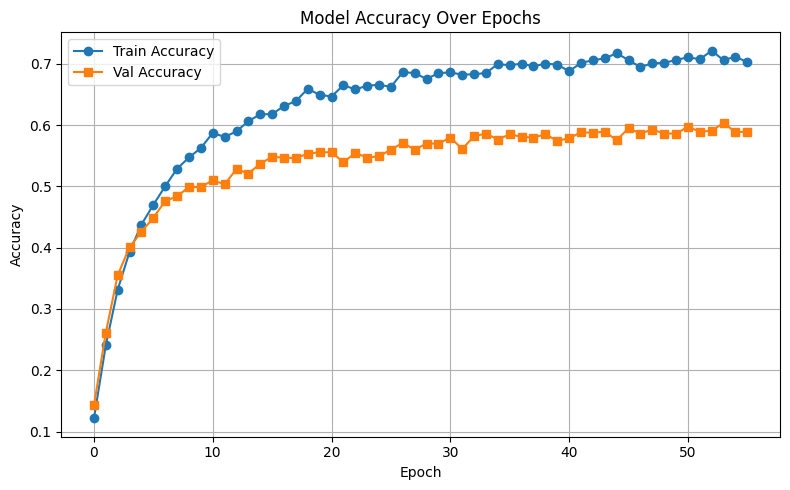

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_transfer.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

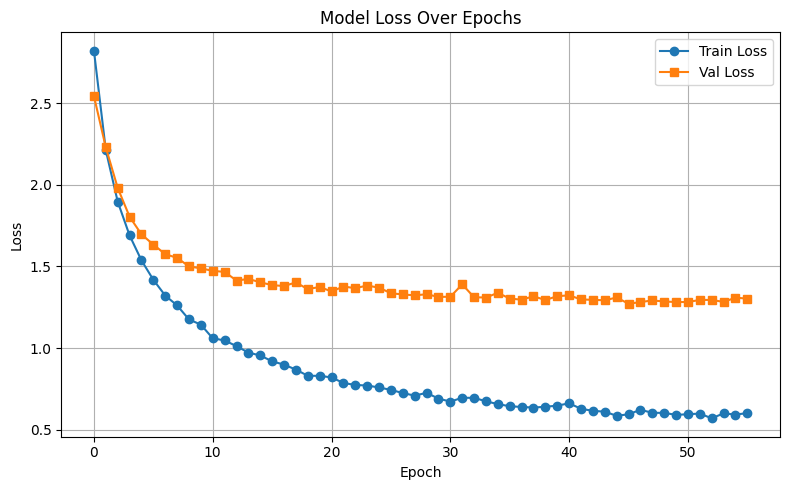

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history_transfer.history['loss'], label='Train Loss', marker='o')
plt.plot(history_transfer.history['val_loss'], label='Val Loss', marker='s')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 865ms/step


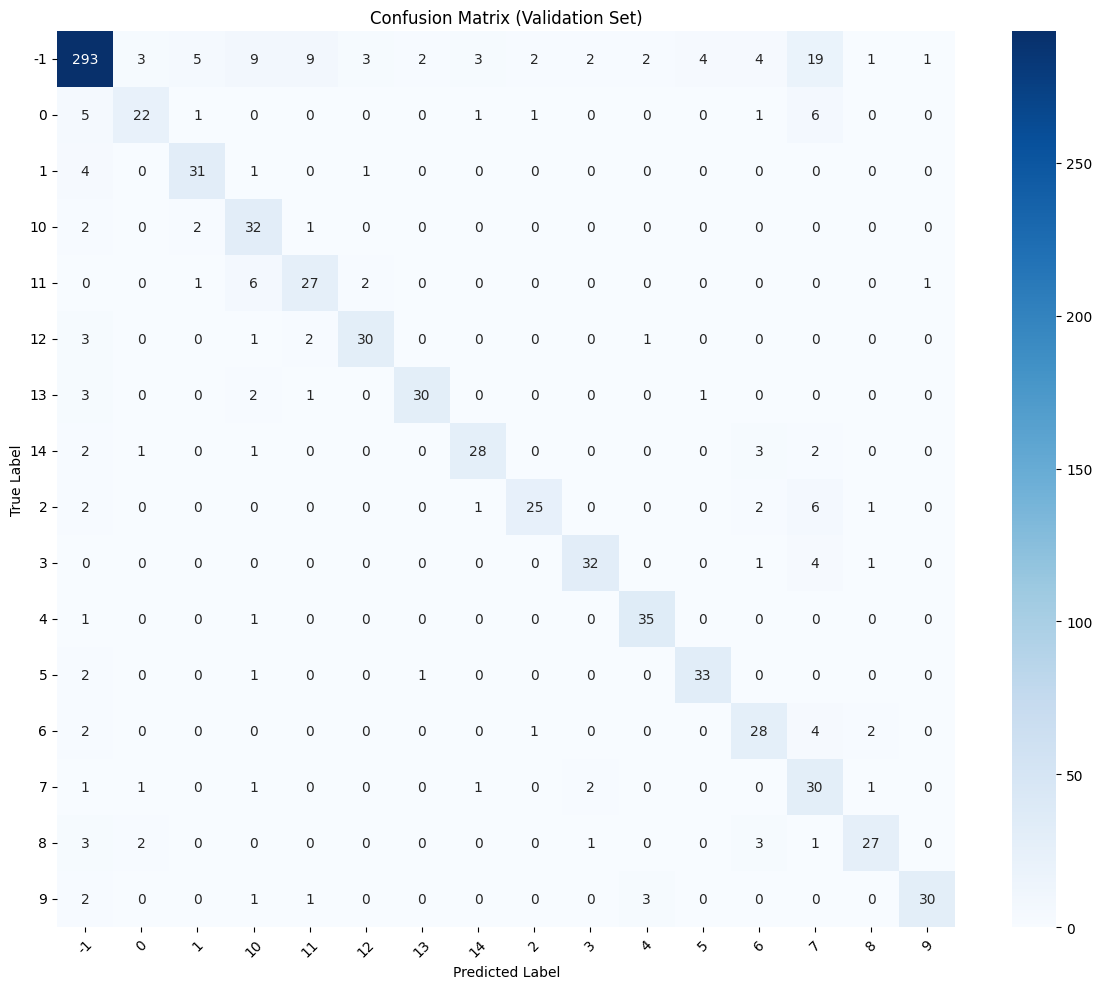

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === 1. Predict on validation data ===
y_val_probs = model.predict(X_val)
y_val_preds = np.argmax(y_val_probs, axis=1)  # Predicted classes
y_val_true = np.argmax(y_val_cat, axis=1)     # True classes

# === 2. Confusion matrix ===
cm = confusion_matrix(y_val_true, y_val_preds)

# === 3. Plot confusion matrix ===
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [14]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model  # If loading model
from sklearn.preprocessing import LabelEncoder

# === CONFIG ===
IMG_SIZE = (256, 384)  # (height, width)
TEST_DIR = "/kaggle/input/project-dataset/Pridect"  # <- Make sure spelling is correct!
NUM_CLASSES = 16

# === LOAD LabelEncoder from TRAINING ===
# Assuming label_encoder is already created during training
# Otherwise, manually restore like:
label_encoder = LabelEncoder()
label_encoder.fit(['-1', '0', '1', '2', '3', '4', '5', '6',
                   '7', '8', '9', '10', '11', '12', '13', '14'])  # must match training folders

# === LOAD TEST IMAGES ===
test_images = []
file_names = []

for fname in sorted(os.listdir(TEST_DIR)):
    fpath = os.path.join(TEST_DIR, fname)
    try:
        img = cv2.imread(fpath)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))  # width, height
            test_images.append(img)
            file_names.append(fname)
    except:
        continue

X_test = np.array(test_images, dtype=np.float32) / 255.0
print(f"✅ Loaded {len(X_test)} test images.")

# === PREDICT ===
pred_probs = model.predict(X_test)  # shape: (n_samples, 16)
top1_preds_encoded = np.argmax(pred_probs, axis=1)

# === DECODE LABELS (Back to -1 to 14 as string) ===
top1_preds_decoded = label_encoder.inverse_transform(top1_preds_encoded)

# === SAVE SUBMISSION FILE ===
submission_df = pd.DataFrame({
    'Id': file_names,
    'label': top1_preds_decoded
})
submission_df.to_csv("F2021376087-7.csv", index=False)
print("✅ Submission file saved: F2021376087-6.csv")


✅ Loaded 425 test images.
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
✅ Submission file saved: F2021376087-6.csv


In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ground truth and predictions
y_val_true = np.argmax(y_val_cat, axis=1) - 1
y_val_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_probs, axis=1) - 1

# Metrics
print("Top-1 Accuracy:", accuracy_score(y_val_true, y_val_pred))
print("F1 Score:", f1_score(y_val_true, y_val_pred, average='weighted'))
print("Precision:", precision_score(y_val_true, y_val_pred, average='weighted'))
print("Recall:", recall_score(y_val_true, y_val_pred, average='weighted'))

# Top-2 Accuracy
top2_preds = np.argsort(y_val_probs, axis=1)[:, -2:]
top2_correct = [true in pred for true, pred in zip(y_val_true, top2_preds)]
top2_accuracy = np.mean(top2_correct)
print("Top-2 Accuracy:", round(top2_accuracy * 100, 2), "%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred, digits=4))


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step
Top-1 Accuracy: 0.7984749455337691
F1 Score: 0.8051839437112587
Precision: 0.8246969570769495
Recall: 0.7984749455337691
Top-2 Accuracy: 8.71 %

Classification Report:
              precision    recall  f1-score   support

          -1     0.9015    0.8094    0.8530       362
           0     0.7586    0.5946    0.6667        37
           1     0.7750    0.8378    0.8052        37
           2     0.5714    0.8649    0.6882        37
           3     0.6585    0.7297    0.6923        37
           4     0.8333    0.8108    0.8219        37
           5     0.9091    0.8108    0.8571        37
           6     0.8235    0.7568    0.7887        37
           7     0.8621    0.6757    0.7576        37
           8     0.8649    0.8421    0.8533        38
           9     0.8537    0.9459    0.8974        37
          10     0.8684    0.8919    0.8800        37
          11     0.6667    0.7568    0.7089        37
          12     0.4167    0.8108 